In [12]:
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

In [186]:
# functions for bandpass filtering
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def calc_sync_index(df_voltage):
    sync_index = (df_voltage['senders'].nunique() * df_voltage.groupby('times')['V_m'].mean().std()) / df_voltage.groupby('senders')['V_m'].std().sum()
    return sync_index

def plot_avalanche(df_spike, num_bin):
    [avalanche_size,bins] = np.histogram(df_spike["times"],bins=int(num_bin))
    [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size)
    plt.plot(bins_avalanche_size[:-1], hist_avalanche_size)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('size of avalanches')
    plt.ylabel('Frequency')
    
def calc_avalanche_size(df_spike, num_bin):
    [avalanche_array,bins] = np.histogram(df_spike["times"],bins=int(num_bin))
    avalanche_size = 0
    asize_list = []
    for avalanche in avalanche_array:
        if avalanche == 0 and avalanche_size != 0:
            asize_list.append(avalanche_size)
            avalanche_size = 0
        elif avalanche == 0 and avalanche_size == 0:
            avalanche_size = 0
        else:
            avalanche_size += avalanche
    asize_list.append(avalanche_size)
    return np.array(asize_list)

def loglog_avalanche(df_spike, num_bin):
    avalanche_size = calc_avalanche_size(df_spike, num_bin)
    [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(1.0),np.log10(100.0), 100),density=True)
    nonzero_index = np.nonzero(hist_avalanche_size)
    bins_avalanche_size = bins_avalanche_size[nonzero_index]
    hist_avalanche_size = hist_avalanche_size[nonzero_index]
    plt.plot(bins_avalanche_size, hist_avalanche_size)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('size of avalanches')
    plt.ylabel('Frequency')

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_weight_matrices(E_neurons, I_neurons):

    W_EE = np.zeros([len(E_neurons), len(E_neurons)])
    W_EI = np.zeros([len(I_neurons), len(E_neurons)])
    W_IE = np.zeros([len(E_neurons), len(I_neurons)])
    W_II = np.zeros([len(I_neurons), len(I_neurons)])

    a_EE = nest.GetConnections(E_neurons, E_neurons)

    # We extract the value of the connection weight for all the connections between these populations
    c_EE = a_EE.weight

    # Repeat the two previous steps for all other connection types
    a_EI = nest.GetConnections(I_neurons, E_neurons)
    c_EI = a_EI.weight
    a_IE = nest.GetConnections(E_neurons, I_neurons)
    c_IE = a_IE.weight
    a_II = nest.GetConnections(I_neurons, I_neurons)
    c_II = a_II.weight

    # We now iterate through the range of all connections of each type.
    # To populate the corresponding weight matrix, we begin by identifying
    # the source-node_id (by using .source) and the target-node_id.
    # For each node_id, we subtract the minimum node_id within the corresponding
    # population, to assure the matrix indices range from 0 to the size of
    # the population.

    # After determining the matrix indices [i, j], for each connection
    # object, the corresponding weight is added to the entry W[i,j].
    # The procedure is then repeated for all the different connection types.
    a_EE_src = a_EE.source
    a_EE_trg = a_EE.target
    a_EI_src = a_EI.source
    a_EI_trg = a_EI.target
    a_IE_src = a_IE.source
    a_IE_trg = a_IE.target
    a_II_src = a_II.source
    a_II_trg = a_II.target

    min_E = min(E_neurons.tolist())
    min_I = min(I_neurons.tolist())

    for idx in range(len(a_EE)):
        W_EE[a_EE_src[idx] - min_E, a_EE_trg[idx] - min_E] += c_EE[idx]
    for idx in range(len(a_EI)):
        W_EI[a_EI_src[idx] - min_I, a_EI_trg[idx] - min_E] += c_EI[idx]
    for idx in range(len(a_IE)):
        W_IE[a_IE_src[idx] - min_E, a_IE_trg[idx] - min_I] += c_IE[idx]
    for idx in range(len(a_II)):
        W_II[a_II_src[idx] - min_I, a_II_trg[idx] - min_I] += c_II[idx]

    fig = plt.figure()
    fig.suptitle('Weight matrices', fontsize=14)
    gs = gridspec.GridSpec(4, 4)
    ax1 = plt.subplot(gs[:-1, :-1])
    ax2 = plt.subplot(gs[:-1, -1])
    ax3 = plt.subplot(gs[-1, :-1])
    ax4 = plt.subplot(gs[-1, -1])

    plt1 = ax1.imshow(W_EE, cmap='jet')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(plt1, cax=cax)

    ax1.set_title('$W_{EE}$')
    plt.tight_layout()

    plt2 = ax2.imshow(W_IE)
    plt2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(plt2, cax=cax)
    ax2.set_title('$W_{EI}$')
    plt.tight_layout()

    plt3 = ax3.imshow(W_EI)
    plt3.set_cmap('jet')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(plt3, cax=cax)
    ax3.set_title('$W_{IE}$')
    plt.tight_layout()

    plt4 = ax4.imshow(W_II)
    plt4.set_cmap('jet')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(plt4, cax=cax)
    ax4.set_title('$W_{II}$')
    plt.tight_layout()

In [3]:
# set the parameters of Wang&Buzaki into hh model
parameters_wang_buzsaki = {
    "t_ref": 2,
    "g_Na": 3500,
    "g_K": 900,
    "g_L": 10,
    "C_m": 100,
    "E_Na": 55,
    "E_K": -90,
    "E_L": -65,
    "V_T": -55,
    "tau_syn_ex": 3,
    "tau_syn_in": 4,
    "E_ex": 0,
    "E_in": -75,
    "I_e": 0
}
nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
# nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)

In [182]:
result_dir = pathlib.Path('./result_palmigiano')
result_dir.mkdir(exist_ok=True)
# nest.print_time = True
# PI_array = np.arange(0.1,1.0,0.1)
# input_rate_array = np.arange(0.1,1.0,0.1)
PI_array = np.array([0.2])
input_rate_array = np.array([0.2])
sync_index_array = np.zeros((len(input_rate_array),len(PI_array)))
for i_input_rate, input_rate in enumerate(input_rate_array):
    for i_PI, PI in enumerate(PI_array):
        nest.ResetKernel()
        # nest.CopyModel("hh_cond_exp_traub", "wang_buzsaki", params=parameters_wang_buzsaki)
        nest.SetDefaults("hh_cond_exp_traub", parameters_wang_buzsaki)
        T = 2000.0
        # create neurons
        NE = 1000
        NI = 250
        Vth = nest.GetDefaults("hh_cond_exp_traub", "V_T")
        Vrest = nest.GetDefaults("hh_cond_exp_traub", "E_L")
        E_neurons  = nest.Create("hh_cond_exp_traub", NE)
        dVms_E =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(E_neurons))]}
        E_neurons.set(dVms_E)
        I_neurons = nest.Create("hh_cond_exp_traub", NI)
        dVms_I =  {"V_m": [Vrest+(Vth-Vrest)*np.random.rand() for x in range(len(I_neurons))]}
        I_neurons.set(dVms_I)

        # create synapses
        PE = 0.3
        CE = int(PE * NE)  # the number of local excitatory connections
        CI = int(PI * NI)  # the number of local inhibitory connections
        d_mean = 1.5 # mean synaptic delay
        gs_E = 5 / NE
        gs_I = -200 / NI

        nest.Connect(E_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CE},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_E, 'delay': d_mean})

        nest.Connect(I_neurons, E_neurons + I_neurons,
                    conn_spec={'rule': 'fixed_indegree', 'indegree': CI},
                    syn_spec={'synapse_model': 'static_synapse', 'weight': gs_I, 'delay': d_mean})


        # create poisson inputs
        rate_poisson = input_rate*10e3 # PI*10kHz
        pg_e = nest.Create("poisson_generator")
        pg_e.set({"start": 0.0, "stop": T,"rate": rate_poisson})
        conn_spec_dict_E = {'rule': 'fixed_total_number', 'N': round(CE)}
        conn_spec_dict_I = {'rule': 'fixed_total_number', 'N': round(CI)}
        syn_spec_cidt_input = {'weight': 1.0, 'delay': 1.5}
        nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E, syn_spec=syn_spec_cidt_input)
        nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I, syn_spec=syn_spec_cidt_input)
        # nest.Connect(pg_e, E_neurons, conn_spec=conn_spec_dict_E)
        # nest.Connect(pg_e, I_neurons, conn_spec=conn_spec_dict_I)

        # connect devices
        voltmeter = nest.Create("voltmeter")
        nest.Connect(voltmeter, E_neurons)
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(E_neurons, spikerecorder)

        # run simulation
        nest.Simulate(T)

        # calculate LFP-like signal
        voltage = pd.DataFrame(voltmeter.get("events"))
        voltage_sorted = voltage.groupby("senders")[["times", "V_m"]].apply(lambda g: g.values.tolist()).to_dict()
        LFP_like = voltage.groupby('times')['V_m'].mean()
        LFP_like = LFP_like.to_numpy()
        time = voltmeter.get("events")["times"][::NE]
        
        [spectrum, freqs, t, im] = plt.specgram(LFP_like,Fs=1000,scale='dB')
        plt.close()

        # plot
        plt.figure(figsize=(7,5))
        plt.subplot(221)
        plt.plot(time[400:1000],LFP_like[400:1000])
        plt.title("LFP")
        plt.xlabel("Time [ms]")
        plt.ylabel("V [mV]")

        plt.subplot(222)
        fs = 1000.0
        lowcut = 30.0
        highcut = 100.0
        y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
        plt.plot(time[400:1000],y[400:1000])
        plt.title("Gamma activity")
        plt.xlabel("Time [ms]")

        plt.subplot(223)
        plt.contourf(t[:20],freqs[10:30],spectrum[10:30,:20],cmap='plasma')
        plt.title("Spectrogram around Gamma")
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Hz]")

        plt.subplot(224)
        plt.plot(freqs[2:25], np.mean(spectrum,1)[2:25])
        plt.title("Mean power")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Power [dB]")

        plt.tight_layout()
        fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
        plt.savefig(result_dir / fname)
        plt.close()
        
        sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
        try:
            nest.raster_plot.from_device(spikerecorder, hist=True)
            plt.title('Population dynamics')
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
            plt.savefig(result_dir / fname)
            
            plt.close()
            
            spike = pd.DataFrame(spikerecorder.get("events"))
            mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
            print(mean_firing_rate)
            
            # plot avalanche
            loglog_avalanche(spike,int(T*10.9))
            fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
            plt.savefig(result_dir / fname)
            plt.close()
            
            # avalanche_size = calc_avalanche_size(spike,int(T/4))
            # [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
            # plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
            # plt.yscale('log')
            # plt.xscale('log')
            # fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
            # plt.savefig(result_dir / fname)
            # plt.close()
        except:
            print("No spikes!")


Jun 29 07:20:36 NodeManager::prepare_nodes [Info]: 
    Preparing 1253 nodes for simulation.

Jun 29 07:20:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Not using MPI

Jun 29 07:21:04 SimulationManager::run [Info]: 
    Simulation finished.
1003.8197183496513


In [183]:
import pickle
fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.pickle"
with open(result_dir / fname , 'wb') as f:
    pickle.dump(spike, f)

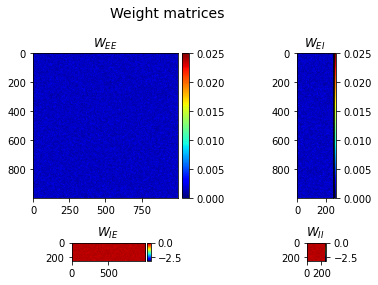

In [187]:
plot_weight_matrices(E_neurons,I_neurons)

In [157]:

# plot
plt.figure(figsize=(7,5))
plt.subplot(221)
plt.plot(time[400:1000],LFP_like[400:1000])
plt.title("LFP")
plt.xlabel("Time [ms]")
plt.ylabel("V [mV]")

plt.subplot(222)
fs = 1000.0
lowcut = 30.0
highcut = 100.0
y = butter_bandpass_filter(LFP_like, lowcut, highcut, fs, order=6)
plt.plot(time[400:1000],y[400:1000])
plt.title("Gamma activity")
plt.xlabel("Time [ms]")

plt.subplot(223)
plt.contourf(t[:20],freqs[10:30],spectrum[10:30,:20],cmap='plasma')
plt.title("Spectrogram around Gamma")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

plt.subplot(224)
plt.plot(freqs[2:25], np.mean(spectrum,1)[2:25])
plt.title("Mean power")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

plt.tight_layout()
fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + ".png"
plt.savefig(result_dir / fname)
plt.close()

sync_index_array[i_input_rate,i_PI] = calc_sync_index(voltage)
try:
    nest.raster_plot.from_device(spikerecorder, hist=True)
    plt.title('Population dynamics')
    fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_raster.png"
    plt.savefig(result_dir / fname)
    
    plt.close()
    
    spike = pd.DataFrame(spikerecorder.get("events"))
    mean_firing_rate = spike.groupby('senders')["times"].apply(lambda g: np.mean(g.values.tolist())).mean()
    print(mean_firing_rate)
    
    # plot avalanche
    loglog_avalanche(spike,int(T*10.9))
    fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche.png"
    plt.savefig(result_dir / fname)
    plt.close()
    
    # avalanche_size = calc_avalanche_size(spike,int(T/4))
    # [hist_avalanche_size, bins_avalanche_size] = np.histogram(avalanche_size,bins=np.logspace(np.log10(8.0),np.log10(800.0), 50),density=True)
    # plt.scatter(bins_avalanche_size[:-1], hist_avalanche_size)
    # plt.yscale('log')
    # plt.xscale('log')
    # fname = "PI_" + str(round(PI,3)) + "_InputRate_" + str(round(input_rate,3)) + "_avalanche_scatter.png"
    # plt.savefig(result_dir / fname)
    # plt.close()
except:
    print("No spikes!")


4998.759093870326


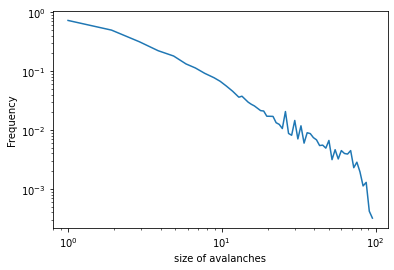

In [163]:
loglog_avalanche(spike,int(T*10.4))